# General Setup

In [ ]:
import math
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt

import numpy as np
from scipy.integrate import solve_ivp, quad
from numpy.linalg import inv
class TimeGridError(Exception):
    pass

class UpdateERROR(Exception):
    pass

# Exercise 1

In [ ]:
class LQR:
    def __init__(self, H, M, C, D, R, t_0 = 0, T = 1, n=100):
      self.H = H
      self.M = M
      self.C = C
      self.D = D
      self.R = R
      self.t_0 = t_0
      self.T = T
      self.number_of_time_steps = n
      self.tau = np.divide(T - t_0, self.number_of_time_steps)
      self.D_inv = inv(self.D)

    #-----------helper classes------------------
    def change_no_of_time_steps(self,n):
        self.number_of_time_steps = n
        self.tau = np.divide(self.T-self.t_0,n)

    def update_t_0_and_T(self, t_0,T, n=None):
        self.t_0 = t_0
        self.T = T
        if n is None:
            n = self.number_of_time_steps
        self.change_no_of_time_steps(n)
        time_grid_check = get_time_grid(self.t_0,self.T, self.tau)
        counter = 0
        for t in time_grid_check:
            counter+=1
        counter-=1
        if self.number_of_time_steps != counter:
            raise UpdateERROR

    #-----------helper classes------------------

    def ricatti_ode(self, t, Q, H, M, C, D):
      # using Q' = -S'(T-t)
      Q = Q.reshape(2, 2)
      dq = 2* H.T @ Q - Q @ M @ np.linalg.inv(D) @ M @ Q + C
      return dq.flatten()

    def solve_ricatti_ode(self, time_grid):
      if len(time_grid) == 1:
        return [self.R]
      S_T = self.R.flatten() # initial y_0 must be 1-d
      res = solve_ivp(self.ricatti_ode, (time_grid[0], time_grid[-1]), S_T, t_eval=time_grid, args=(self.H, self.M, self.C, self.D))
      return res.y.T.reshape(-1, 2, 2)[::-1]

    def control_problem_value(self, time_tensor, space_tensor, sigma):
      v = []
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid) 
        integral = 0
        for s_t in S:
          integral += np.trace(sigma @ sigma.transpose() * s_t) * self.tau

        v_values = x @ S[0] @ torch.t(x) + integral
        v.append(v_values.flatten()[0])
      return torch.tensor(v)

    def markov_control(self, time_tensor, space_tensor):
      a = np.zeros(shape=(1, 2))
      d_inv = inv(self.D)
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid)
        a = np.vstack((a,(-d_inv @ self.M.transpose() @ S[0] @ x.numpy().transpose()).transpose()))

      return torch.tensor(a[1:])

#-----------helper classes------------------
def round_nearest(num: float, to: float) -> float:
    return round(num / to) * to

def round_down(num: float, to: float) -> float:
    nearest = round_nearest(num, to)
    if math.isclose(num, nearest): return num
    return nearest if nearest < num else nearest - to

def get_time_grid(t_0,T,tau_size):
    t_0 = torch.tensor(t_0)
    part_no = np.divide(T-t_0, tau_size)
    tt = np.divide(T-t_0, part_no)
    grid = np.arange(t_0.item(), T+0.00001, tt)
    return grid
#-----------helper classes------------------

dim = 2
H = np.identity(dim)
M = np.identity(dim)
C = 0.1 * np.identity(dim)
D = 0.1 * np.identity(dim)
R = np.identity(dim)
sigma = np.array([0.05,0.05])  # 2 rows  d dimensional columns for R-d dim wiener

T = 1.0
t_0 = 0.5

lqr = LQR(H, M, C, D, R, t_0, T)

batch_size = 1

#Sample function calls
time_grid = get_time_grid(t_0, T, 0.01)
S = lqr.solve_ricatti_ode(time_grid)

time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=batch_size)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size,1, 2)))

v= lqr.control_problem_value(time_tensor, space_tensor, sigma)
a= lqr.markov_control(time_tensor, space_tensor)


<ipython-input-2-0eb4abd959ca>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


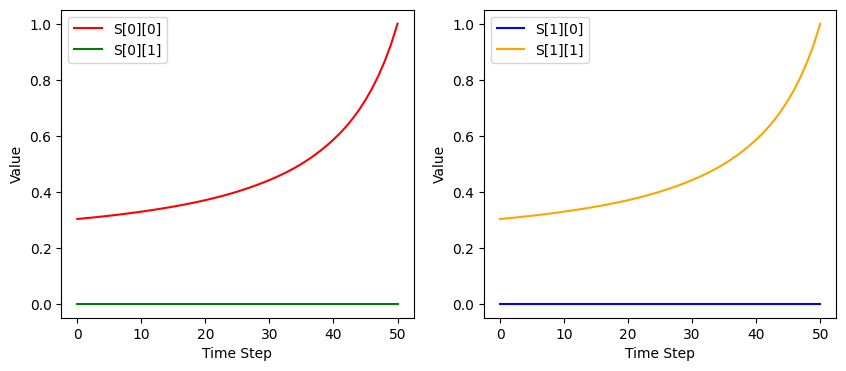

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot([s[0][0] for s in S], label='S[0][0]', color='red')
ax[0].plot([s[0][1] for s in S], label='S[0][1]', color='green')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Value')
ax[0].legend()

ax[1].plot([s[1][0] for s in S], label='S[1][0]', color='blue')
ax[1].plot([s[1][1] for s in S], label='S[1][1]', color='orange')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Value')
ax[1].legend()

In [ ]:
# 1.2
def get_time_grid(t_0,T,tau_size):
    if t_0 == T:
        return np.array([T])
    # t_0 = torch.tensor(t_0)
    part_no = np.divide(T-t_0, tau_size)
    tt = np.divide(T-t_0, part_no)
    grid = np.arange(t_0, T+0.00001, tt)
    # grid = np.arange(round_nearest(t_0.item(),tau_size), T+tau_size*0.9, tau_size)
    # if not math.isclose(grid[-1],T,abs_tol=tau_size*0.01):
    #     raise TimeGridError
    return grid

# 1.2
def monte_carlo_S_0(lqr_setup, time_tensor_singular):
      time_grid = get_time_grid(time_tensor_singular,lqr_setup.T, lqr_setup.tau)
      S = lqr_setup.solve_ricatti_ode(time_grid)
      return S[0]

def monte_carlo_variable_time_steps(lqr_monte, batch_size, x_np):
    H = torch.tensor(np.copy(lqr_monte.H))
    M = torch.tensor(np.copy(lqr_monte.M))
    D_inv = torch.tensor(np.copy(lqr_monte.D_inv))

    x_t = {}
    a_t = {}
    tau_dict = {}
    for number_of_time_steps in [1, 10, 50, 100, 500, 1000, 5000]:
        lqr_monte.change_no_of_time_steps(number_of_time_steps)
        time_grid_monte_carlo = get_time_grid(lqr_monte.t_0,lqr_monte.T, lqr_monte.tau)
        starting_space_tensor = torch.tensor(np.tile(x_np, batch_size).reshape(batch_size,1,2))
        space_tensor_monte_carlo = starting_space_tensor

        tau_dict[number_of_time_steps] = lqr_monte.tau
        x_t[number_of_time_steps] =[]
        a_t[number_of_time_steps] =[]
        x_t[number_of_time_steps].append(space_tensor_monte_carlo)

        for t_k in time_grid_monte_carlo:
            random_component = torch.randn(batch_size, 1,2) * np.sqrt(lqr_monte.tau) * sigma
            s_t_n = monte_carlo_S_0(lqr_monte, t_k)

            alpha_no_x_t_n = - D_inv @ M.T @ s_t_n
            alpha_control = torch.matmul(alpha_no_x_t_n , space_tensor_monte_carlo.transpose(1, 2)).reshape(batch_size,2)

            x_t_n_coeff = H +(M @ alpha_no_x_t_n)
            X_t_step = lqr_monte.tau*torch.matmul(x_t_n_coeff , space_tensor_monte_carlo.transpose(1, 2)).transpose(1, 2)
            X_t_next_monte_carlo = space_tensor_monte_carlo + X_t_step + random_component

            space_tensor_monte_carlo = X_t_next_monte_carlo
            a_t[number_of_time_steps].append(alpha_control)
            if t_k != time_grid_monte_carlo[-1]:
                x_t[number_of_time_steps].append(X_t_next_monte_carlo)
    return x_t,a_t, tau_dict

def monte_carlo_variable_batch_size(lqr_monte, number_of_time_steps, x_np):
    H = torch.tensor(np.copy(lqr_monte.H))
    M = torch.tensor(np.copy(lqr_monte.M))
    D_inv = torch.tensor(np.copy(lqr_monte.D_inv))

    lqr_monte.change_no_of_time_steps(number_of_time_steps)

    x_t = {}
    a_t = {}
    tau_dict = {}
    time_grid_monte_carlo = get_time_grid(lqr_monte.t_0,lqr_monte.T, lqr_monte.tau)

    for sample_size in [10,50,100,500,1000, 5000, 10000, 50000]:
        x_t[sample_size] =[]
        a_t[sample_size] =[]
        tau_dict[sample_size] = lqr_monte.tau

    for batch_step in [10,50,100,500,1000, 5000, 10000, 50000,100000]:
        starting_space_tensor = torch.tensor(np.tile(x_np, batch_step).reshape(batch_step,1,2))
        space_tensor_monte_carlo = starting_space_tensor

        tau_dict[batch_step] = lqr_monte.tau
        x_t[batch_step] =[]
        a_t[batch_step] =[]
        x_t[batch_step].append(space_tensor_monte_carlo)

        for t_k in time_grid_monte_carlo:
            random_component = torch.randn(batch_step, 1,2) * np.sqrt(lqr_monte.tau) * sigma
            s_t_n = monte_carlo_S_0(lqr_monte, t_k)
            alpha_no_x_t_n = - D_inv @ M.T @ s_t_n
            alpha_control = torch.matmul(alpha_no_x_t_n , space_tensor_monte_carlo.transpose(1, 2)).reshape(batch_step,2)

            x_t_n_coeff = H +(M @ alpha_no_x_t_n)
            X_t_step = lqr_monte.tau*torch.matmul(x_t_n_coeff , space_tensor_monte_carlo.transpose(1, 2)).transpose(1, 2)
            X_t_next_monte_carlo = space_tensor_monte_carlo + X_t_step + random_component

            #
            # alpha_monte_carlo = lqr_monte.markov_control(time_tensor_monte_carlo, space_tensor_monte_carlo)
            # X_t_next_monte_carlo = space_tensor_monte_carlo + lqr_monte.tau*(torch.matmul(H, space_tensor_monte_carlo.transpose(1, 2)) + torch.matmul(M, alpha_monte_carlo.reshape(batch_step,2,1))).transpose(1, 2) + random_component

            space_tensor_monte_carlo = X_t_next_monte_carlo
            a_t[batch_step].append(alpha_control)
            if t_k != time_grid_monte_carlo[-1]:
                x_t[batch_step].append(X_t_next_monte_carlo)

    return x_t,a_t, tau_dict


def compute_expected_J(x_t,a_t, tau_dict, lqr_monte, is_n_variable):
    J = {}
    monte_carlo_J_mean = {}
    theoretical_v_values = {}
    theoretical_alpha_value = {}
    lqr_monte.change_no_of_time_steps(5000)

    for key in x_t:
        J[key] =0
        delta_tau = tau_dict[key]

        x_s_prev, a_s_prev = x_t[key][0], a_t[key][0]
        batch_shape = x_s_prev.shape[0]
        for x_s, a_s in zip(x_t[key][1:], a_t[key][1:]):
            x_C_x_prev = torch.matmul(torch.matmul(x_s_prev, torch.tensor(C)),x_s_prev.transpose(1, 2)).reshape(batch_shape,1)
            a_D_a_prev= (torch.matmul(a_s_prev, torch.tensor(D)) * a_s_prev).sum(axis=1).reshape(batch_shape,1)

            x_C_x = torch.matmul(torch.matmul(x_s, torch.tensor(C)),x_s.transpose(1, 2)).reshape(batch_shape,1)
            a_D_a= (torch.matmul(a_s, torch.tensor(D)) * a_s).sum(axis=1).reshape(batch_shape,1)

            J[key] += 0.5*(x_C_x + a_D_a + x_C_x_prev + a_D_a_prev) * delta_tau
            x_s_prev, a_s_prev = x_s.detach().clone(), a_s.detach().clone()

        x_T = x_t[key][-1]
        J[key] += torch.matmul(torch.matmul(x_T, torch.tensor(R)),x_T.transpose(1, 2)).reshape(batch_shape,1)

        monte_carlo_J_mean[key] = torch.mean(J[key]).item()

        if is_n_variable:
            lqr_monte.change_no_of_time_steps(key)
        t_tensor = torch.tensor(np.array(lqr_monte.t_0)).reshape(1,1)
        s_tensor = x_t[key][0]
        theoretical_v_values[key] = lqr_monte.control_problem_value(t_tensor, s_tensor, sigma).item()
        theoretical_alpha_value[key] = lqr_monte.markov_control(t_tensor, s_tensor)


    # print(monte_carlo_J_mean)
    # print(theoretical_v_values)
    err=[]
    for key in monte_carlo_J_mean:
        err.append(np.abs(monte_carlo_J_mean[key] - theoretical_v_values[key]))
    return monte_carlo_J_mean,theoretical_v_values,err


lqr_monte = LQR(H, M, C, D, R,  0, 1)
n_step_sim ={'monte_carlo_J_mean':[],'theoretical_v_values':[],'err':[]}
n_batch_sim ={'monte_carlo_J_mean':[],'theoretical_v_values':[],'err':[]}
for sim in [np.array((3.0,2.0)),np.array((0.0,1.2)),np.array((0.3,0.1)),np.array((0.9,-2.0)),np.array((-0.5,-1.5)),np.array((3.0,3.0)),np.array((-3.0,-3.0)),np.array((0.0,0.0))]:
    print(sim)
    x_t_n_steps,a_t_n_steps, tau_dict_n_steps = monte_carlo_variable_time_steps(lqr_monte, batch_size=100000, x_np=np.array((3.0,2.0)))
    monte_carlo_J_mean,theoretical_v_values,err = compute_expected_J(x_t_n_steps,a_t_n_steps,  tau_dict_n_steps, lqr_monte, True)
    n_step_sim['monte_carlo_J_mean'].append(monte_carlo_J_mean)
    n_step_sim['theoretical_v_values'].append(theoretical_v_values)
    n_step_sim['err'].append(err)

    x_t_batch,a_t_batch, tau_dict_batch = monte_carlo_variable_batch_size(lqr_monte, number_of_time_steps=5000, x_np=np.array((0.4,0.1)))
    monte_carlo_J_mean,theoretical_v_values,err = compute_expected_J(x_t_batch,a_t_batch,  tau_dict_batch, lqr_monte, False)
    n_batch_sim['monte_carlo_J_mean'].append(monte_carlo_J_mean)
    n_batch_sim['theoretical_v_values'].append(theoretical_v_values)
    n_batch_sim['err'].append(err)

for simulation,error in zip(n_step_sim['theoretical_v_values'],n_step_sim['err']):
    plt.loglog([a for a in simulation], error)
plt.show()

for simulation,error in zip(n_batch_sim['theoretical_v_values'],n_batch_sim['err']):
    plt.loglog([a for a in simulation], error)
plt.show()
# print(err)
# plt.loglog([a for a in theoretical_v_values], err)
# plt.show()

[3. 2.]


# Exercise 2

In [ ]:
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)


    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [ ]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).to(torch.float64))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).to(torch.float64)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).to(torch.float64)


## Exercise 2.1

In [ ]:
# 2.1 takes roughly 12 minutes to train 
t_0 = 0
T = 1
batch_size = 256

time_tensor_dim = 1
space_tensor_dim = 1 * 2

dmg_hidden_layer_size = 100
ffm_hidden_layer_size = 100

loss_improvement_limit = 20
max_num_epochs = 1000

# Define the loss function
loss_function = nn.MSELoss()

lqr_2 = LQR(H, M, C, D, R, t_0, T)


# 2.1 Value function
# Use Exercise 1.1 to generate the value for training data
lqr_2.update_t_0_and_T(t_0=t_0,T=T,n=100)

# Generate prediction
net_dgm = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)

# Create the optimizer
optimizer = torch.optim.Adam(net_dgm.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0
while train:
    epoch_counter +=1
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)

    y = lqr_2.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)
    y_pred = net_dgm.forward(t_tensor, x_reshaped).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    net_dgm.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False
training_loss_net_dgm = loss

<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


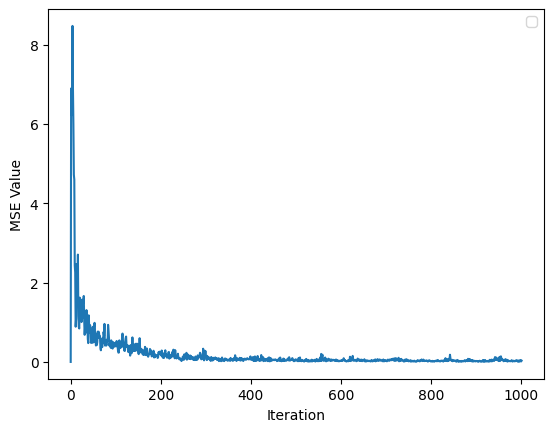

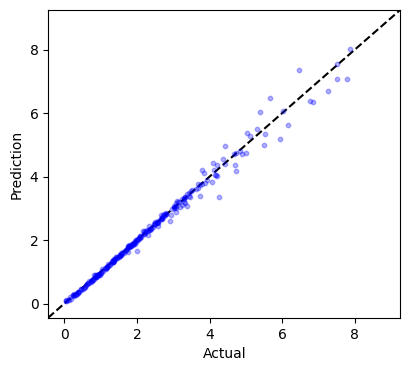

Value Neural Network Training Loss MSE 0.032703322779309436


<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


Validation Loss MSE 0.023817606676941248
Specific Value pred 3.9946932624378264, theoretical value 3.9366972120660604


In [ ]:
# Plot losses over iteration
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.legend()
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

print('Value Neural Network Training Loss MSE {}'.format(training_loss_net_dgm))

# Validation testing
t_tensor_val = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
x_tensor_val = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
x_reshaped_val = x_tensor_val.reshape(-1, 2)
# input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

y = lqr_2.control_problem_value(t_tensor_val, x_tensor_val, sigma).unsqueeze(1)
y_pred = net_dgm.forward(t_tensor_val, x_reshaped_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred, y)
print('Validation Loss MSE {}'.format(loss))

# Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y = lqr_2.control_problem_value(time_tensor, space_tensor, sigma).unsqueeze(1)
y_pred = net_dgm.forward(time_tensor, x_reshaped).to(torch.float64)
print('Specific Value pred {}, theoretical value {}'.format(y_pred.item(),y.item()))


## Exercise 2.2

In [ ]:
#2.2
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
net_ffn_control = FFN(sizes = sizes)
optimizer = torch.optim.Adam(net_ffn_control.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0

while train:
    epoch_counter +=1
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)
    input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

    y = lqr_2.markov_control(t_tensor, x_tensor)
    y_pred = net_ffn_control.forward(input_tensor).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred.reshape(batch_size,2), y.reshape(batch_size,2))
    losses.append(loss.item())
    net_ffn_control.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False



<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


Control Neural Network Training Loss MSE 1.1305987904209185
Specific Value pred tensor([[-9.1788, -6.5757]], dtype=torch.float64, grad_fn=<AddmmBackward0>), theoretical value tensor([[[-9.0792, -6.0528]]], dtype=torch.float64)


<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


Validation Loss MSE 1.7140182343855876


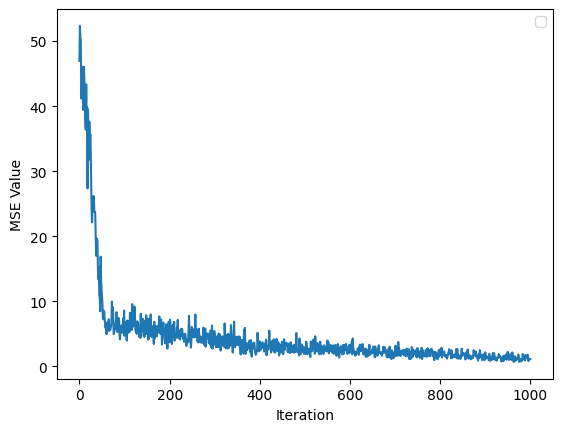

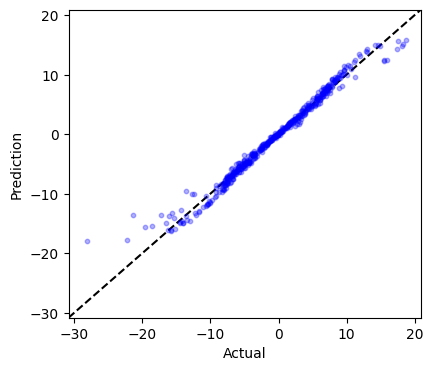

In [ ]:
training_loss_net_ffm = loss

losses = losses[1:]
print('Control Neural Network Training Loss MSE {}'.format(training_loss_net_ffm))

#Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y = lqr_2.markov_control(time_tensor, space_tensor).unsqueeze(1)
y_pred = net_ffn_control.forward(input_tensor).to(torch.float64)
print('Specific Value pred {}, theoretical value {}'.format(y_pred,y))


y = lqr_2.markov_control(t_tensor_val, x_tensor_val).unsqueeze(1)
input_tensor_val = torch.cat((t_tensor_val, x_reshaped_val), dim=1)
y_pred = net_ffn_control.forward(input_tensor_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred.reshape(batch_size,2), y.reshape(batch_size,2))
print('Validation Loss MSE {}'.format(loss))

# Plot losses over iteration
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.legend()
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()



# Exercise 3

<ipython-input-10-174226680e8e>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
100%|██████████| 1000/1000 [02:39<00:00,  5.78it/s]

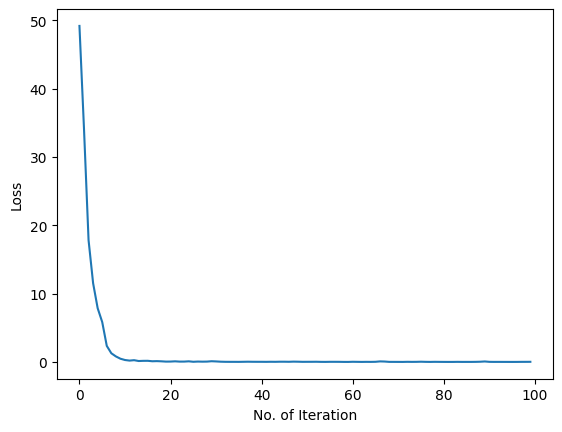

[49.1976354404321, 45.48776358326176, 45.01448946668318, 44.937856862621736, 50.83014083565405, 50.109927717435355, 44.48995015052951, 41.05527585035195, 40.69581219224038, 32.65282274946064, 34.1183488439496, 28.60881050342267, 26.011764839719735, 26.64720756889797, 24.440842408193333, 20.578424718543097, 21.33307152647085, 19.526728901894604, 17.773768375750674, 16.79817954312854, 17.8393480673819, 16.010671530122757, 19.917134781544465, 14.531697940904023, 17.744903576944417, 15.014374708682674, 14.609571104682356, 14.716086993479683, 12.937207159290898, 13.5100012723413, 11.526161275310182, 14.380032859695536, 11.075568028261173, 11.260503733413588, 12.237669396973844, 10.5226197945689, 11.301356058287423, 8.620362542195855, 8.418393012522667, 9.079851113216831, 7.869145970629925, 6.6915755451951435, 7.208512407603358, 7.635323922375115, 8.306691897583644, 6.44792854837804, 5.723325027540065, 5.790227017749327, 5.522938655186378, 5.224263304553208, 5.841640666755444, 4.286135518689

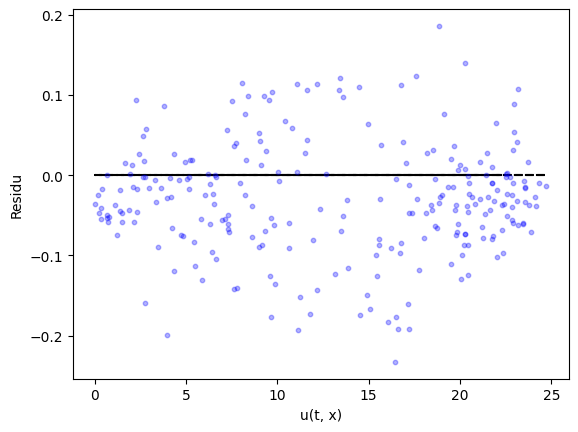

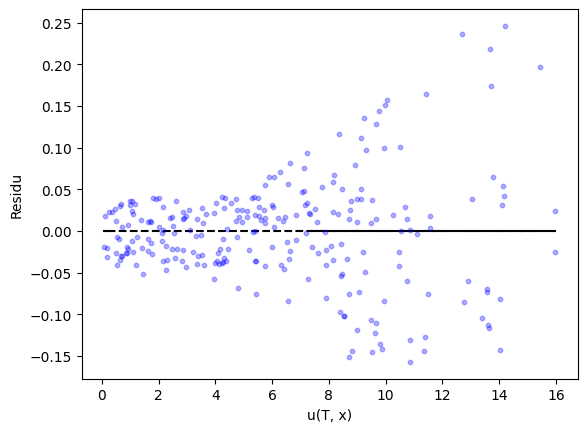

100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


In [ ]:
lqr_3 = LQR(H, M, C, D, R, t_0=0, T=1)
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hessian(grad, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1])
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
    return hessian.to(torch.float64)


class PDE_DGM(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma, alpha=np.array([1.0, 1.0]).T):
        super().__init__()
        self.H = torch.tensor(H)
        self.M = torch.tensor(M)
        self.C = torch.tensor(C)
        self.D = torch.tensor(D)
        self.R = torch.tensor(R)
        self.sigma = torch.tensor(sigma).reshape(2,1)
        self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
        self.alpha = torch.tensor(alpha).reshape(2,1)
        self.M_alpha = self.M @ self.alpha
        self.a_D_a = self.alpha.T @ self.D @ self.alpha
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = (10000,) ,gamma=0.1)
        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            t_tensor = torch.tensor(np.random.uniform(low=lqr_3.t_0, high=lqr_3.T, size=batch_size),requires_grad=True).unsqueeze(1)#lqr_3.t_0 + lqr_3.T*torch.rand(batch_size, 1, requires_grad=True)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)
            u_of_tx = self.net_dgm(t_tensor, x_tensor)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            M_alpha_grad = torch.matmul(grad_u_x,self.M_alpha)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + self.a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_3.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
            u_of_tx_terminal = self.net_dgm(t_tensor_terminal, x_tensor_terminal)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx_terminal, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)

        if plot:
            # Plot training loss graph
            plt.plot(losses[0::10])
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            print(losses)

            # Plot loss over equation 1
            plt.scatter(u_of_tx.detach().numpy(), pde.detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx.detach().numpy(), torch.zeros_like(u_of_tx).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('u(t, x)')
            plt.ylabel('Residu')
            plt.show()

            # Plot loss over equation 2
            plt.scatter(u_of_tx_terminal.detach().numpy(), (u_of_tx_terminal- target_boundary).detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx_terminal.detach().numpy(), torch.zeros_like(u_of_tx_terminal).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('u(T, x)')
            plt.ylabel('Residu')
            plt.show()

    def forward(self, t_tensor, x_tensor):
        return self.net_dgm.forward(t_tensor, x_tensor).to(torch.float64)


dgm = PDE_DGM(H, M, C, D, R, sigma)
dgm.fit(256, 1000, plot=True)

In [ ]:
# testing
def test_3(H, M, C, D, R, sigma):
    batch_size = 1
    H = torch.tensor(H)
    M = torch.tensor(M)
    C = torch.tensor(C)
    D = torch.tensor(D)
    R = torch.tensor(R)
    sigma = torch.tensor(sigma).reshape(2,1)
    sigma_sigma_t = torch.tensor(sigma @ sigma.T)
    alpha = np.array([1.0, 1.0]).T
    alpha = torch.tensor(alpha).reshape(2,1)
    M_alpha = M @ alpha
    a_D_a = alpha.T @ D @ alpha
    t_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=(batch_size, 1)), requires_grad=True)
    x_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)), requires_grad=True)
    u_of_tx = dgm.forward(t_tensor, x_tensor)
    grad_u_x = get_gradient(u_of_tx, x_tensor)
    grad_u_t = get_gradient(u_of_tx, t_tensor)
    hessian = get_hessian(grad_u_x, x_tensor)
    target_equation = torch.zeros_like(u_of_tx)

    trace_sigma_sigma_hessian = torch.matmul(sigma_sigma_t,hessian)
    trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
    H_x_grad = (grad_u_x *  torch.transpose((H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
    M_alpha_grad = torch.matmul(grad_u_x,M_alpha)
    x_C_x = (x_tensor *  torch.transpose((C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

    pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

    t_tensor_terminal = torch.ones(batch_size, 1) * 1
    x_tensor_terminal = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)))
    u_of_tx_bound = dgm.forward(t_tensor_terminal, x_tensor_terminal)
    target_boundary = (x_tensor_terminal *  torch.transpose((R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size, 1)

    print(f'Equation 1: {pde}, Target: 0')
    print(f'u(T,x): {u_of_tx_bound}, Target: {target_boundary}')

test_3(H, M, C, D, R, sigma)

Equation 1: tensor([[0.0640]], dtype=torch.float64, grad_fn=<AddBackward0>), Target: 0
u(T,x): tensor([[13.1403]], dtype=torch.float64, grad_fn=<AddmmBackward0>), Target: tensor([[13.]], dtype=torch.float64)


<ipython-input-11-265351ee096a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_sigma_t = torch.tensor(sigma @ sigma.T)


QUESTION 4 (no tests yet)

In [ ]:
# MODIFIED
lqr_q_4 = LQR(H, M, C, D, R, t_0=0, T=1)
class PDE_DGM_modified(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma):
        super().__init__()
        self.H = torch.tensor(H)
        self.M = torch.tensor(M)
        self.C = torch.tensor(C)
        self.D = torch.tensor(D)
        self.R = torch.tensor(R)
        self.sigma = torch.tensor(sigma).reshape(2,1)
        self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim + 2 - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,), gamma=0.1)

        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            t_tensor = lqr_q_4.t_0 + lqr_q_4.T*torch.rand(batch_size, 1, requires_grad=True)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)
            alpha_train = lqr_q_4.markov_control(t_tensor.detach().numpy(), x_tensor.detach().reshape(batch_size,1,2))

            u_of_tx = self.forward_mod(t_tensor, x_tensor, alpha_train)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            M_alpha_grad = (grad_u_x *  torch.transpose((self.M @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size,1)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            a_D_a = (alpha_train *  torch.transpose((self.D @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size,1)



            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_q_4.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
            u_of_tx = self.forward_mod(t_tensor_terminal, x_tensor_terminal,alpha_train)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)
            if loss < 0.05:
              return

        if plot:
            # Plot training loss graph
            plt.plot(losses[0::10])
            plt.title('Training loss over iteration')
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            print(losses)

    def forward_mod(self, t_tensor, x_tensor, a_tensor):

        return self.net_dgm.forward(t_tensor, torch.cat((x_tensor, a_tensor), dim=1)).to(torch.float64)

dgm_q_4 = PDE_DGM_modified(H, M, C, D, R, sigma)
dgm_q_4.fit(512, 5000, plot=True)

<ipython-input-12-8528353c0ead>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
 80%|████████  | 4000/5000 [2:37:33<39:23,  2.36s/it]


In [ ]:
# Question 4
# Pre-defined parameters

# -------
batch_size = 2048
# Fit estimator for a
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
q_4_a_model = FFN(sizes = sizes)
optimizer_a = torch.optim.Adam(q_4_a_model.parameters(), lr=0.001)

# Generate prediction
q_4_v_model = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)
optimizer_v = torch.optim.Adam(q_4_v_model.parameters(), lr=0.001)

u_model = dgm_q_4

losses_a = []
losses_v = []
# ------
for i in range(10000):
    # pbar = tqdm.tqdm(total=1000)
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    q_4_t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    q_4_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)),requires_grad=True)
    q_4_x_reshaped = q_4_x_tensor.reshape(-1, 2)
    q_4_input_tensor = torch.cat((q_4_t_tensor, q_4_x_reshaped), dim=1)

    # Approximate a
    q_4_a_pred = q_4_a_model.forward(q_4_input_tensor).to(torch.float64)

    # Generate control for v
    q_4_v_actual = u_model.forward_mod(q_4_t_tensor,q_4_x_reshaped,q_4_a_pred)
    # print(f'v_actual:{v_actual}')

    # Approximate v
    q_4_v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped)
    # print(f'v_approx:{v_approx}')

    # Update theta val
    optimizer_v.zero_grad()
    mse_loss = nn.MSELoss()
    loss_v = mse_loss(q_4_v_approx, q_4_v_actual)
    losses_v.append(loss_v.item())
    loss_v.backward(retain_graph=True)
    optimizer_v.step()

    #ii
    v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped)
    # Approximate v using the trained model
    grad_u_x = torch.autograd.grad(v_approx, q_4_x_reshaped, grad_outputs=torch.ones_like(v_approx), create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Calculate Hamiltonian as loss that we are trying to minimize
    hamiltonian = (grad_u_x *  torch.transpose((torch.tensor(H) @ q_4_x_reshaped.T),0,1)).sum(axis=1).reshape(batch_size,1) + \
                  (grad_u_x *  torch.transpose((torch.tensor(M) @ q_4_a_pred.T),0,1)).sum(axis=1).reshape(batch_size,1) +  \
                  (q_4_x_reshaped *  torch.transpose((torch.tensor(C) @ q_4_x_reshaped.T),0,1)).sum(axis=1).reshape(batch_size,1)+\
                    (q_4_a_pred *  torch.transpose((torch.tensor(D) @ q_4_a_pred.T),0,1)).sum(axis=1).reshape(batch_size,1)

    optimizer_a.zero_grad()
    mae_loss_h = nn.L1Loss()
    loss_a_ham = mae_loss_h(hamiltonian, torch.zeros_like(hamiltonian))
    loss_a_ham.backward(retain_graph=True)
    optimizer_a.step()
    losses_a.append(loss_a_ham.item())




Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
Iteration 6000
Iteration 6100
Iteration 6200
Iteration 6300
Iteration 6400
Iteration 6500
Iteration 6600
Iterati

In [ ]:
# Compare with 1.1
batch_size = 1
# Sample t uniformly on [0, T]
t_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=batch_size)).unsqueeze(1)
x_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)))
x_reshaped = x_tensor.reshape(-1, 2)
input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64)
a_actual = lqr_q_4.markov_control(t_tensor, x_tensor)
print(a_pred)
print(a_actual)
# # print(f'MSE of a: {loss_fn(a_pred, a_actual)}')
# #
# # Compare v_pred and v from 1.1
# v_pred = v_model.forward(t_tensor, x_reshaped)
# v_actual = lqr.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)
# print(v_pred)
# print(v_actual)
# # print(f'MSE of v: {loss_fn(v_pred, v_actual)}')

tensor([[-3.1139, -2.6466]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
tensor([[-9.0792, -6.0528]], dtype=torch.float64)


<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


In [ ]:
# Compare with 1.1
batch_size = 100
# Sample t uniformly on [0, T]
t_tensor = torch.tensor(np.random.uniform(low=0.0, high=0.99, size=batch_size)).unsqueeze(1)
x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
x_reshaped = x_tensor.reshape(-1, 2)
input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64)
a_actual = lqr_q_4.markov_control(t_tensor, x_tensor)
q_2_pred = net_ffn_control.forward(input_tensor).to(torch.float64)
print(a_pred)
print(a_actual)
print(q_2_pred)
# print(f'MSE of a: {loss_fn(a_pred, a_actual)}')
# #
# # Compare v_pred and v from 1.1
v_pred = q_4_v_model.forward(t_tensor, x_reshaped)
v_actual = lqr.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)
q_2_v_pred = net_dgm.forward(t_tensor, x_reshaped).to(torch.float64)
print(v_pred)
print(v_actual)
print(q_2_v_pred)
# print(f'MSE of v: {loss_fn(v_pred, v_actual)}')

<ipython-input-2-67f11874e5f4>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0)


tensor([[ 0.2834, -2.1052],
        [ 1.7288,  0.3751],
        [-3.0639,  3.6297],
        [ 4.1016,  1.7851],
        [-2.9047,  0.1530],
        [ 2.3416, -1.1396],
        [-1.2476, -2.1942],
        [-2.2870, -3.0408],
        [-0.4234, -1.4421],
        [ 2.7030, -2.9104],
        [-1.1011, -3.6899],
        [-3.2975,  2.3355],
        [-3.1033,  3.5506],
        [ 2.0251,  2.0926],
        [-1.7146,  3.5184],
        [-3.3196, -1.2724],
        [-2.4902, -2.0935],
        [ 0.4536,  1.0135],
        [ 0.8800,  0.9375],
        [ 2.1753, -2.6724],
        [-2.8738,  3.0007],
        [-3.3481, -0.4752],
        [ 3.3709, -2.1600],
        [ 3.5239,  2.5157],
        [ 2.1809,  2.0335],
        [ 1.5342,  3.1368],
        [ 1.6018,  2.6599],
        [ 0.5881,  3.6398],
        [ 0.7298,  1.8144],
        [-0.9019,  1.0593],
        [ 1.5676,  2.4638],
        [ 3.6470,  0.1250],
        [ 2.8070,  3.6307],
        [-1.9683, -1.0009],
        [ 0.1034, -2.5696],
        [ 1.7076, -1